<a href="https://colab.research.google.com/github/Feynman520/Cosmos/blob/main/Stock_Forecast_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# File Upload

In [24]:
from google.colab import files
upload = files.upload()

Saving sk hynix stock.csv to sk hynix stock (1).csv


# Import Library

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
# from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime



*   pandas : 데이터 분석을 위한 라이브러리
*   numpy : 행렬 연산을 위한 라이브러리
*   matplotlib : 예측 결과를 시각화하기 위한 라이브러리
*   keras : 딥러닝 모델을 간편하게 사용하기 위한 프레임워크
*   datetime : 년월일 시간을 다루기 위한 라이브러리



# Laod Dataset

In [26]:
data = pd.read_csv('sk hynix stock.csv')
display(data.head())
data_index = data.index
print("데이터 전체 행의 수 : ",len(data_index))

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-02-13,49550.0,51000.0,49500.0,50700.0,47186.460938,4124290
1,2017-02-14,51100.0,51600.0,48100.0,48450.0,45092.390625,8593878
2,2017-02-15,48300.0,48700.0,47550.0,47900.0,44580.507813,8725221
3,2017-02-16,48350.0,49600.0,48200.0,49600.0,46162.695313,4840918
4,2017-02-17,50400.0,51100.0,50200.0,50400.0,46907.257813,4927937


데이터 전체 행의 수 :  1225




*   data : 학습, 예측에 사용할 시계열 데이터.
*   저장된 시계열 데이터의 앞부분 1~5번째 데이터를 출력해 확인합니다.
*   data_index : 데이터의 인덱스 행.
*   저장된 data_index의 길이 즉, 데이터의 수를 확인합니다.

▶ sk 하이닉스의 5년치 데이터는 날짜(Data), 시작가(Open), 최고가(Hige), 최저가(Low), 마감가(Close), 수정 종가(Adj Close), 거래 총량(Volume)라는 Feature들로 구성되어 있습니다.<br/>
▶ sk 하이닉스의 5년치 데이터는 총 1225개입니다.

# Compute Mid Price

In [27]:
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2



*   high_prices : sk 하이닉스 데이터의 3열인 최고가(High)에 해당하는 5년치 데이터의 값.
*   Low_prices : sk 하이닉스 데이터의 4열인 최저가(Low)에 해당하는 5년치 데이터의 값.
*   mid_prices : 우리가 학습하고 예측에 사용할 하루의 최고값과 최저값의 평균인 중간값.



# Create Windows

In [28]:
seq_len = 50
sequence_length = seq_len + 1

window_list = []
for index in range(len(mid_prices) - sequence_length):
    window_list.append(mid_prices[index: index + sequence_length])
print("첫번째 window : ",window_list[0])
print("첫번째 window의 길이 : ",len(window_list[0]))
print("window의 총개수 : ",len(window_list))

첫번째 window :  [50250. 49850. 48125. 48900. 50650. 50300. 50175. 51150. 49725. 48700.
 46325. 46900. 47325. 47475. 48475. 48675. 48600. 48425. 48525. 50200.
 51100. 49025. 49075. 47500. 47100. 47625. 47900. 48725. 49750. 50525.
 50650. 51500. 50850. 50350. 51300. 51500. 50475. 49800. 49250. 49350.
 48875. 48875. 49425. 50075. 49700. 49850. 50125. 50700. 51900. 52650.
 52050.]
첫번째 window의 길이 :  51
window의 총개수 :  1174




▶학습, 예측할 데이터 단위는 window 입니다.
*   seq_len : 설정할 window의 학습 근거 데이터수.
*   sequence_length : seq_len + seq_len를 근거로 예측할 데이터수.(window size)
*   window_list : size가 51인 window들의 집합 리스트.<br/>
&#35; 한칸씩 밀리면서 생성한 window를 저장할 빈 리스트 를 생성합니다.(여기에서 window는 numpy array입니다.)
*   한칸씩 밀리면서 생성하기 위해 전체 행의수 1225개에서 51개를 뺀 수만큼 반복을 시작합니다.(index = 0 ~ 1173)
*   mid_prices에서 index ~ index+51 범위 값이 window이므로 window_list에 저장합니다.
*   window_list의 첫번째 window는 2017-02-13 ~ 2017-04-25의 51개 데이터가 저장됩니다.
*   windw의 총개수는 1174개이고, 한개의 window에 들어있는 데이터 개수는 51개 입니다.<br/>
&#35; window : 51개의 데이터를 담고 있는 창문.<br/>
&#35; window_data : window 속 데이터 1개.<br/>
&#35; window_list : 1174개의 window를 모아놓은 리스트.


# Normalize Data

In [29]:
normalized_window_list = []
for window in window_list:
    normalized_window = [((float(window_data) / float(window[0])) - 1) for window_data in window]
    normalized_window_list.append(normalized_window)

result = np.array(normalized_window_list)



▶각 window의 첫번째 데이터를 0으로 잡고, 그 비율을 계산하여 정규화시킵니다.
*   normalized_window_list : 정규화된 winddow의 집합 리스트.
*   1174개의 window를 차례대로 반복 대입합니다.
*   대입한 window는 51개의 데이터를 가지고 있고, 하나씩 꺼내어 window_data에 대입합니다.
*   window_data는 1개의 데이터이며 각 window의 첫번째 window_data를 0으로 잡고, 비율을 계산합니다.

# Split Train and Test Data

In [30]:
print("result의 shape : ",result.shape)
row = int(round(result.shape[0] * 0.9))
print("훈련데이터수 : ",row)
train = result[:row, :]
print("train의 shape : ",train.shape)
np.random.shuffle(train)

x_train = train[:, :-1]
print("x_train의 shape : ",x_train.shape)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]
print("y_train의 shape : ",y_train.shape)

x_test = result[row:, :-1]
print("x_test의 shape : ",x_test.shape)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]
print("y_test의 shape : ",y_test.shape)

x_train.shape, x_test.shape

result의 shape :  (1174, 51)
훈련데이터수 :  1057
train의 shape :  (1057, 51)
x_train의 shape :  (1057, 50)
y_train의 shape :  (1057,)
x_test의 shape :  (117, 50)
y_test의 shape :  (117,)


((1057, 50, 1), (117, 50, 1))


▶51개 데이터를 담은 1174개의 window 집합 2차 array인 result를 분리합니다.
*   row : 정규화된 window들의 90%의 수.<br/>
&#35; 정규화된 window 세트는 result에 저장되어 있으며 result.shape는 (행, 열)이고, 0번째 인덱스는 result에 들어있는 window 세트의 수를 의미합니다.
*   train : result에서 0~row(1057)행에 해당하는 데이터.<br/>
&#35; result[0] = 2017-02-13에서 2017-04-25 까지의 데이터이고, result[1057] = 2021-06-08부터 2021-08-18까지의 데이터 이므로 2021-08-17 이하 데이터를 학습하고 이후 2021-08-19 부터 데이터를 예측하게 됩니다.
*   train 데이터를 무작위로 섞습니다.
*   x_train : window의 90%에 해당하는 데이터 51개 중 제일 마지막 데이터를 제외한 데이터 50개.(input 데이터)
*   LSTM 모델의 입력 노드는 50, 출력 노드는 1이므로 (50,1)로 reshape을 합니다.
*   y_train : window의 90%에 해당하는 데이터 51개 중 제일 마지막 데이터 1개.(output 데이터)<br/>
&#35; 이미지를 다룰때의 이미지(input), 정답(output)과 다름에 유의해야 합니다.
*   x_test : window의 10%에 해당하는 데이터 51개 중 제일 마지막 데이터를 제외한 데이터 50개.(input 데이터)
*   LSTM 모델의 입력 노드는 50, 출력 노드는 1이므로 (50,1)로 reshape을 합니다.
*   y_test : window의 10%에 해당하는 데이터 51개 중 제일 마지막 데이터 1개.(output 데이터)


# Build a Model

In [31]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))

model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 64)                29440     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________




*   model : keras의 seqential() 인스턴스.<br/>
&#35; model은 텅빈 인스턴스로 add를 통해서 layer를 쌓아야 합니다.
*   LSTM layer를 생성하고 sequntial에 추가합니다.<br/>
&#35; 입력되는 데이터의 shape는 (50,1)입니다.
*   출력 layer는 dense 함수를 이용하여 출력 노드 1개, 활성화 함수는 linear로 생성하여 추가합니다.
*   compile 함수를 이용하여 손실함수는 mse, 옵티마이저는 rmsprop을 설정하고 생성하여 추가합니다.
*   완성된 모델 인스턴스를 요약해서 출력합니다.


# Training

In [32]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=20)

Epoch 1/20
106/106 [==============================] - 14s 59ms/step - loss: 0.0034 - val_loss: 9.2407e-04
Epoch 2/20
106/106 [==============================] - 5s 48ms/step - loss: 0.0016 - val_loss: 7.1759e-04
Epoch 3/20
106/106 [==============================] - 5s 49ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 4/20
106/106 [==============================] - 5s 47ms/step - loss: 9.3037e-04 - val_loss: 5.1300e-04
Epoch 5/20
106/106 [==============================] - 5s 47ms/step - loss: 7.2015e-04 - val_loss: 9.8728e-04
Epoch 6/20
106/106 [==============================] - 5s 47ms/step - loss: 5.9110e-04 - val_loss: 9.7111e-04
Epoch 7/20
106/106 [==============================] - 5s 47ms/step - loss: 5.5120e-04 - val_loss: 5.8048e-04
Epoch 8/20
106/106 [==============================] - 5s 48ms/step - loss: 5.3435e-04 - val_loss: 5.9050e-04
Epoch 9/20
106/106 [==============================] - 5s 47ms/step - loss: 5.2523e-04 - val_loss: 4.0415e-04
Epoch 10/20
106/106 [=============



*   완성된 모델을 fit함수를 이용하여 학습시킵니다.<br/>
&#35; 준비했던 학습, 평가 데이터를 설정하고, batch의 크기는 10개로 에폭은 20으로 설정합니다.



# Prediction

In [33]:
pred = model.predict(x_test)
pred_table = []
for i in pred:
  pred_table.append((i+1)*float(window[0]))

date = pd.date_range(start="20210902", end="20220211",freq='C')
date_table = list(date)

a = {'Date': date_table, 'Prices': pred_table}
b = pd.DataFrame(a)

display(b)

,Date,Prices
0,2021-09-02,[97243.08]
1,2021-09-03,[99666.98]
2,2021-09-06,[100644.56]
3,2021-09-07,[97144.0]
4,2021-09-08,[97889.65]
...,...,...
112,2022-02-07,[135648.84]
113,2022-02-08,[125079.45]
114,2022-02-09,[119641.95]
115,2022-02-10,[121736.67]




*   pred : 학습된 모델이 x_test에 대한 예측값을 모아놓은 array.
*   정규화된 모델 예측값을 다시 역연산하고, pred_table에 추가합니다.
*   date : 판다스의 date_range함수를 사용하여 2021-08-31부터 2022-02-09 범위의 주중 날짜.
*   date의 자료형을 리스트로 변환하고, date_table과 pred_table을 이용하여 DataFrame을 생성합니다.<br/>
&#35; 2021-08-19을 포함한 이후로 2022-02-11까지 주중일은 총 127일이나 중간에 비규칙적으로 주식시장 휴일로 117개의 데이터가 존재합니다. 그래서 우선은 부득이하게 2021-09-02부터 날짜를 시작함을 알려드립니다.


# Data Visualization

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


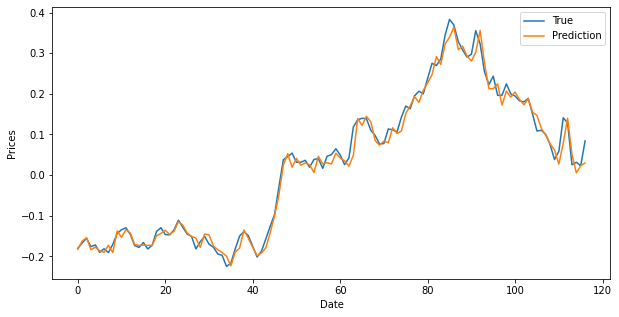

In [34]:
fig = plt.figure(facecolor='white', figsize=(10, 5))
plt.xlabel("Date")
plt.ylabel("Prices")
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

# Price Forecast for Tomorrow

In [47]:
to_data = result[1173, 1:]
to_x_data = np.reshape(to_data, (1,to_data.shape[0], 1))

to_pred = model.predict(to_x_data)
to_pred = list((to_pred+1)*float(window[0]))

a = {'Date': ["2022-02-14"], 'Prices': to_pred}
b = pd.DataFrame(a)

display(b)

,Date,Prices
0,2022-02-12,[129992.36]


# Price Forecast for Week

In [57]:
new_data = result[1173, 1:]
new_data = np.reshape(new_data, (1,new_data.shape[0], 1))
we_pred_list = []
for i in range(10):
  new_pred = model.predict(new_data)
  we_pred = (new_pred+1)*float(window[0])
  we_pred = np.reshape(we_pred, (1))
  we_pred_list.append(we_pred)
  new_pred = np.reshape(new_pred, (1,1,1))
  new_data = np.concatenate([new_data,new_pred],axis=1)
  new_data = new_data[:,1:,:]

date = pd.date_range(start="20220214", end="20220225",freq='C')
new_date_list = list(date)

table = {'Date': new_date_list, 'Prices': we_pred_list}
week = pd.DataFrame(table)

display(week)


,Date,Prices
0,2022-02-14,[129992.36]
1,2022-02-15,[129381.24]
2,2022-02-16,[128527.336]
3,2022-02-17,[127742.41]
4,2022-02-18,[127104.305]
5,2022-02-21,[126587.84]
6,2022-02-22,[126142.6]
7,2022-02-23,[125726.516]
8,2022-02-24,[125314.62]
9,2022-02-25,[124896.516]


# Week Data Visualization

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


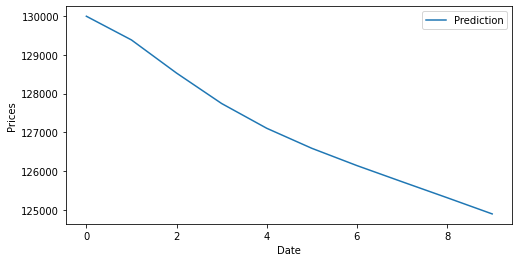

In [64]:
fig = plt.figure(facecolor='white', figsize=(8, 4))
plt.xlabel("Date")
plt.ylabel("Prices")
ax = fig.add_subplot(111)
ax.plot(we_pred_list, label='Prediction')
ax.legend()
plt.show()